## Barotropic streamfunction

Compared with data from [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1)

Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
#cc.start_cluster()
client = Client('tcp://10.0.64.16:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.16:8786 Dashboard: http://10.0.64.16:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [7]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)\
                                        .sel(time=slice(tstart,tend))\
                                        .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_1998-2017.nc')
    
    return gyre_psi

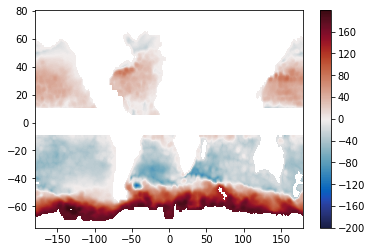

In [8]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [9]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
cmp = plt.get_cmap('gist_ncar_r')

In [10]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_1deg.load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 26.9 s, sys: 19.9 s, total: 46.8 s
Wall time: 59.2 s


In [11]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_025deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_025deg.load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 28.7 s, sys: 20.2 s, total: 48.9 s
Wall time: 1min 28s


In [12]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

sea_level = cc.get_nc_variable(expt,'ocean_daily.nc','eta_t',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_01deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_01deg.load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 2min 23s, sys: 26.3 s, total: 2min 49s
Wall time: 40min 55s


In [13]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
gyre_psi_1deg = get_gyre_psi('1deg')
gyre_psi_025deg = get_gyre_psi('025deg')
gyre_psi_01deg = get_gyre_psi('01deg')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


In [15]:
## All data is now loaded - make a dictionary for plotting
gyre_psi_dict = {'1deg': gyre_psi_1deg, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
sla_rms_dict = {'1deg': sla_rms_1deg, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


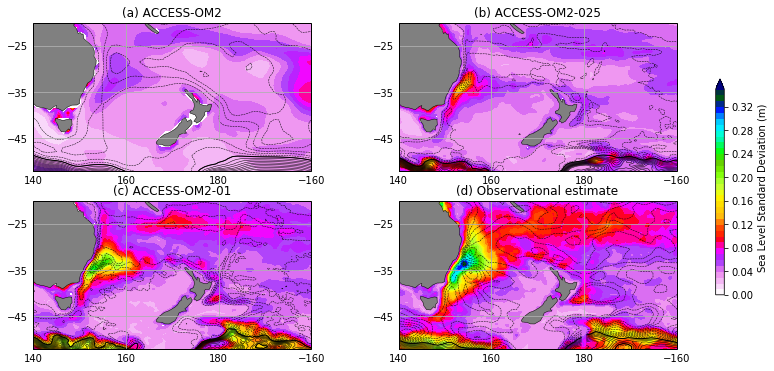

In [16]:
# EAC Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-50,80.01,5)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('eac_barotropic_streamfunctions')

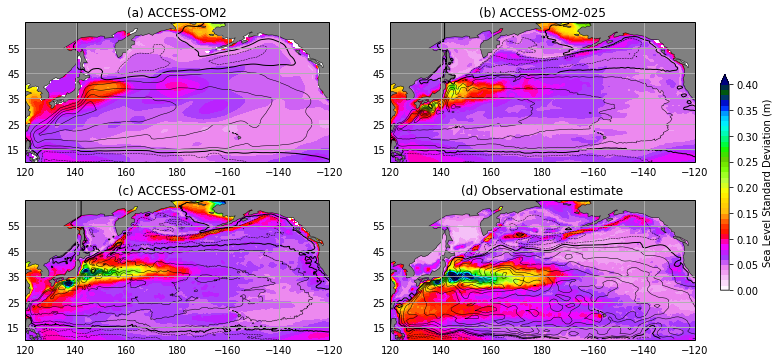

In [39]:
# Kuroshio Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.401,0.01)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False

p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('kuroshio_barotropic_streamfunctions')

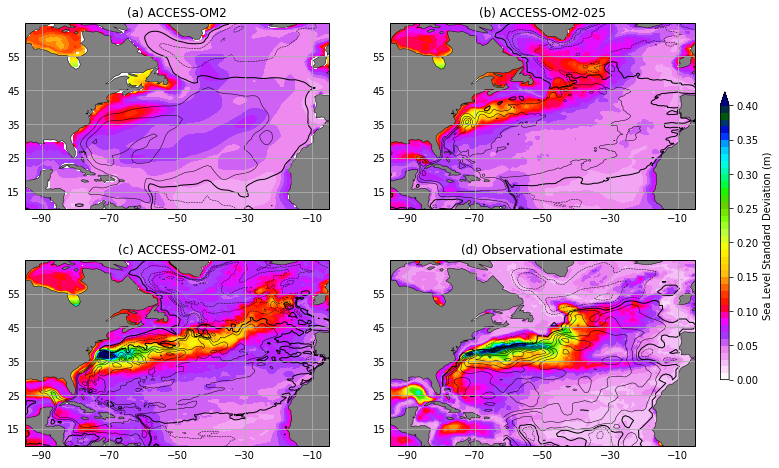

In [37]:
# Gulf Stream Region
plt.figure(figsize(12,8))
clev = np.arange(0,0.401,0.01)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('gulfstream_barotropic_streamfunctions')

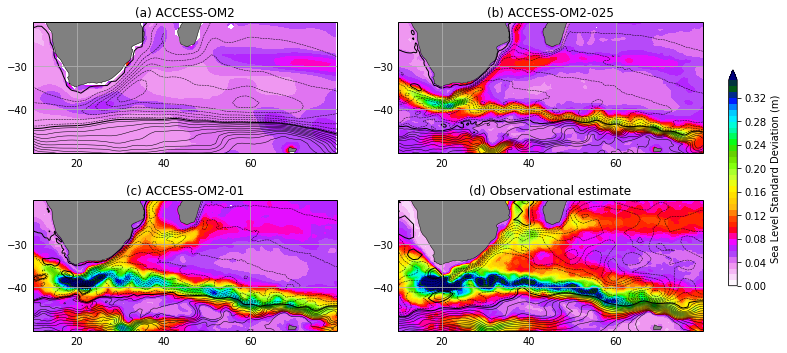

In [17]:
# Agulhas Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-75,125.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
    gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('agulhas_barotropic_streamfunctions')

In [ ]:
# Antarctic Region
plt.figure(figsize(15,15))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    ax = plt.subplot(2,2,i+1,projection=ccrs.SouthPolarStereo())
    ax.add_feature(land_50m)
#     ax.set_extent([10, 80, -50, -20], crs=ccrs.SouthPolarStereo())
   # gl = ax.gridlines(crs=ccrs.SouthPolarStereo(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
    gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])
    break


ax = plt.subplot(2,2,4,projection=ccrs.SouthPolarStereo())
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.SouthPolarStereo()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('acc_barotropic_streamfunctions')

# Everything below here uses old basemap methods.

In [ ]:
def global_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-160,160.01,2)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def agulhas_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)
    
    map = Basemap(llcrnrlon=10,llcrnrlat=-50,urcrnrlon=79.9,urcrnrlat=-20,
             resolution='l', projection='cyl', lat_0 = 35, lon_0 = -35)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-50.,-20.,10.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(0.,81.,20.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t,geolat_t)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def kuroshio_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-240,urcrnrlon=-120,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def gulfstream_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-95,urcrnrlon=-5,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def eac_map_psi(gyre_psi,geolon,geolat):
    clev = np.arange(-30,30.01,1)
    clev2 = np.arange(-25,25.01,5)
    
    map = Basemap(projection='cyl',llcrnrlat=-55,urcrnrlat=-20,\
            llcrnrlon=-220,urcrnrlon=-140,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

## Plot gyre transport, with DP transport subtracted

This is the plot designed for the model evaluation paper.

In [ ]:
%%time
plt.figure(1,figsize(8,12))
plt.figure(2,figsize(12,6))
plt.figure(3,figsize(12,6))
plt.figure(4,figsize(12,8))
plt.figure(5,figsize(12,6))

plot_labels=['(a) ','(b) ','(c) ']

#for i, ekey in enumerate(exptdata.exptdict.keys()):
for i, ekey in enumerate(['1deg']):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')
    
    label=plot_labels[i]
    
    plt.figure(1)
    plt.subplot(3,1,i+1)
    p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(2)
    plt.subplot(2,2,i+1)
    p2 =agulhas_map_psi(gyre_psi,geolon_t.values,geolat_t.values)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(3)
    plt.subplot(2,2,i+1)
    p3 = kuroshio_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(4)
    plt.subplot(2,2,i+1)
    p4 = gulfstream_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(5)
    plt.subplot(2,2,i+1)
    p5 = eac_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
plt.figure(1)
ax3 = plt.axes([0.92,0.35,0.02,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('global_barotropic_streamfunctions')

plt.figure(2)
subplot(224)
agulhas_map_psi(psi,lon,lat)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p2,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('agulhas_barotropic_streamfunctions')

plt.figure(3)
subplot(224)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p3,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('kuroshio_barotropic_streamfunctions')

plt.figure(4)
subplot(224)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.3,0.01,0.4])
cb = plt.colorbar(p4,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

plt.figure(5)
subplot(224)
plt.title('(d) .sel(time')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p5,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('eac_barotropic_streamfunctions')